# Clustering for Grouping the People based on TFM and TLM

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE

## Load and Merge Data
Load the cleaned dataset and merge it with cardiovascular fitness data.

In [2]:
data_path = "data/nhanes_cleaned_validated_data.csv"
if not os.path.exists(data_path):
    raise FileNotFoundError(f"Dataset not found at {data_path}. Ensure the preprocessing step was completed.")

health_data = pd.read_csv(data_path)
print(f"Loaded main dataset with shape: {health_data.shape}")

# Load and merge cardiovascular fitness data
cv_data1 = pd.read_csv('csv/1999_2000/cv_level.csv')
cv_data2 = pd.read_csv('csv/2001_2002/cv_level.csv')
cv_data3 = pd.read_csv('csv/2003_2004/cv_level.csv')

cv_data = pd.concat([cv_data1, cv_data2, cv_data3], ignore_index=True)
health_data_with_cv = health_data.merge(cv_data, on='id', how='inner').dropna()

print(f"Merged dataset with CV-level. Shape: {health_data_with_cv.shape}")


Loaded main dataset with shape: (14740, 15)
Merged dataset with CV-level. Shape: (5177, 16)


## Define Feature Sets (With & Without TLM/TFM)
Specify which features will be included for each clustering approach.

In [3]:
# Common numeric features
numerical_features_common = ['bmi', 'age_in_months']

# Features WITH TLM/TFM
numerical_features_tlm_tfm = ['total_fat_mass', 'total_lean_mass']

# Define feature sets
numerical_features_with = numerical_features_common + numerical_features_tlm_tfm
numerical_features_without = numerical_features_common + ['weight', 'height', 'maximal_calf_circumference',
                                                          'arm_circumference', 'waist_circumference', 'thigh_circumference']

# Categorical features (for encoding)
categorical_features = ['gender', 'ethnicity', 'cv_fitness_level']

## Encode and Scale Data
Encode categorical features and standardize numerical features.

In [4]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

encoded_categorical = encoder.fit_transform(health_data_with_cv[categorical_features])
encoded_df = pd.DataFrame(encoded_categorical, columns=encoder.get_feature_names_out(categorical_features),
                          index=health_data_with_cv.index)

scaler = StandardScaler()
data_with_scaled = scaler.fit_transform(pd.concat([health_data_with_cv[numerical_features_with], encoded_df], axis=1))
data_without_scaled = scaler.fit_transform(pd.concat([health_data_with_cv[numerical_features_without], encoded_df], axis=1))

## Find Optimal Number of Clusters (Using BIC & AIC)
Determine the best K for Gaussian Mixture Model (GMM) clustering.

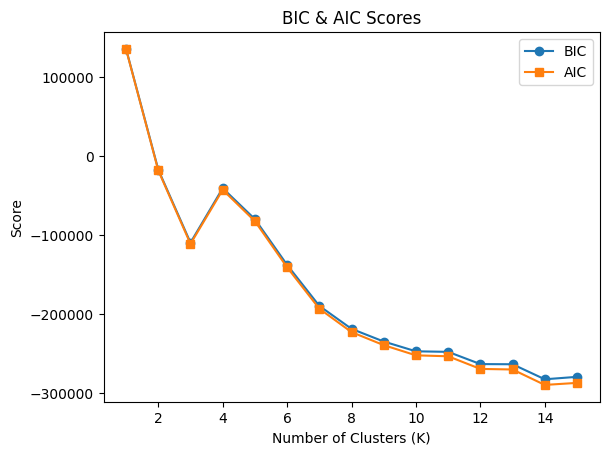

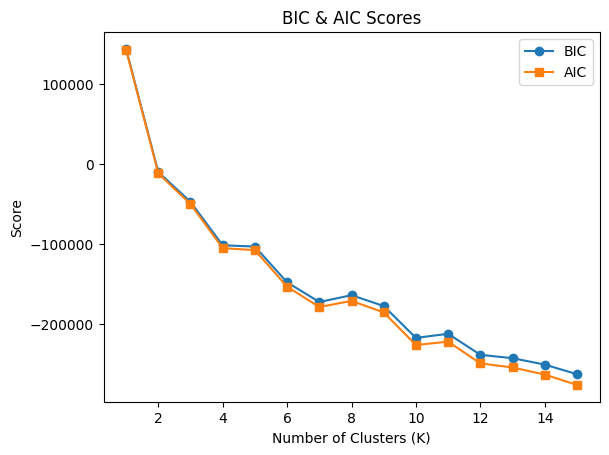

Optimal K (WITH TLM/TFM): 14
Optimal K (WITHOUT TLM/TFM): 15


In [5]:
def find_optimal_k(data_scaled, k_range=range(1, 16)):
    bic_scores = []
    aic_scores = []
    
    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=42)
        gmm.fit(data_scaled)
        bic_scores.append(gmm.bic(data_scaled))
        aic_scores.append(gmm.aic(data_scaled))
    
    # Plot BIC/AIC scores
    plt.figure()
    plt.plot(k_range, bic_scores, marker='o', label="BIC")
    plt.plot(k_range, aic_scores, marker='s', label="AIC")
    plt.xlabel("Number of Clusters (K)")
    plt.ylabel("Score")
    plt.legend()
    plt.title("BIC & AIC Scores")
    plt.show()
    
    return k_range[np.argmin(bic_scores)]

optimal_k_with = find_optimal_k(data_with_scaled)
optimal_k_without = find_optimal_k(data_without_scaled)

print(f"Optimal K (WITH TLM/TFM): {optimal_k_with}")
print(f"Optimal K (WITHOUT TLM/TFM): {optimal_k_without}")

## Perform Clustering with GMM
Run Gaussian Mixture Model clustering for both cases.

In [6]:
gmm_with = GaussianMixture(n_components=optimal_k_with, random_state=42, reg_covar=1e-2)
clusters_with = gmm_with.fit_predict(data_with_scaled)

gmm_without = GaussianMixture(n_components=optimal_k_without, random_state=42, reg_covar=1e-2)
clusters_without = gmm_without.fit_predict(data_without_scaled)

health_data_with_cv["cluster_with"] = clusters_with
health_data_with_cv["cluster_without"] = clusters_without

## Evaluate Clustering Performance
Compute silhouette, Davies-Bouldin, and Calinski-Harabasz scores.

In [7]:
def evaluate_clusters(data_scaled, labels, description):
    silhouette = silhouette_score(data_scaled, labels)
    davies_bouldin = davies_bouldin_score(data_scaled, labels)
    calinski_harabasz = calinski_harabasz_score(data_scaled, labels)
    
    print(f"Clustering Quality ({description}):")
    print(f"  - Silhouette Score: {silhouette:.4f} (higher is better)")
    print(f"  - Davies-Bouldin Index: {davies_bouldin:.4f} (lower is better)")
    print(f"  - Calinski-Harabasz Index: {calinski_harabasz:.4f} (higher is better)\n")

evaluate_clusters(data_with_scaled, clusters_with, "With TLM/TFM")
evaluate_clusters(data_without_scaled, clusters_without, "Without TLM/TFM")

Clustering Quality (With TLM/TFM):
  - Silhouette Score: 0.2570 (higher is better)
  - Davies-Bouldin Index: 1.4703 (lower is better)
  - Calinski-Harabasz Index: 651.3743 (higher is better)

Clustering Quality (Without TLM/TFM):
  - Silhouette Score: 0.0973 (higher is better)
  - Davies-Bouldin Index: 1.8803 (lower is better)
  - Calinski-Harabasz Index: 338.4533 (higher is better)


## Compare Clustering Overlap (ARI & NMI)
Use Adjusted Rand Index (ARI) and Normalized Mutual Info (NMI).

In [8]:
ari = adjusted_rand_score(clusters_with, clusters_without)
nmi = normalized_mutual_info_score(clusters_with, clusters_without)

print("\n=== Clustering Overlap Metrics ===")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Info (NMI): {nmi:.4f}")


=== Clustering Overlap Metrics ===
Adjusted Rand Index (ARI): 0.7162
Normalized Mutual Info (NMI): 0.8422


## Visualize Clusters with t-SNE
Reduce dimensionality to 2D for visualization.

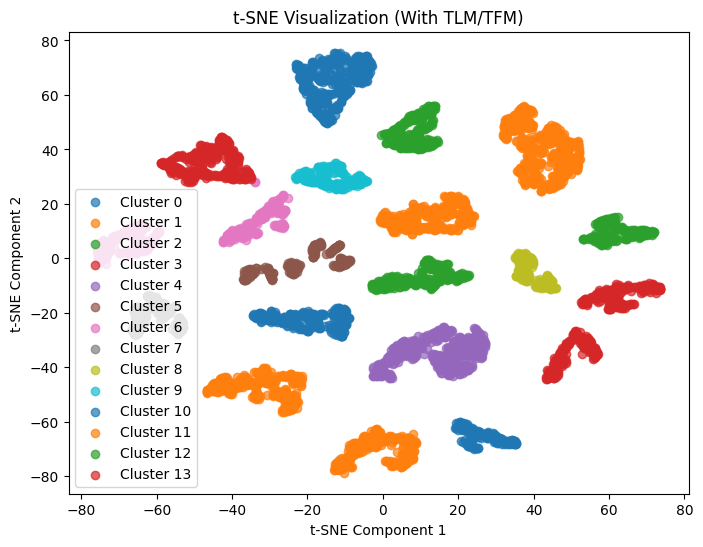

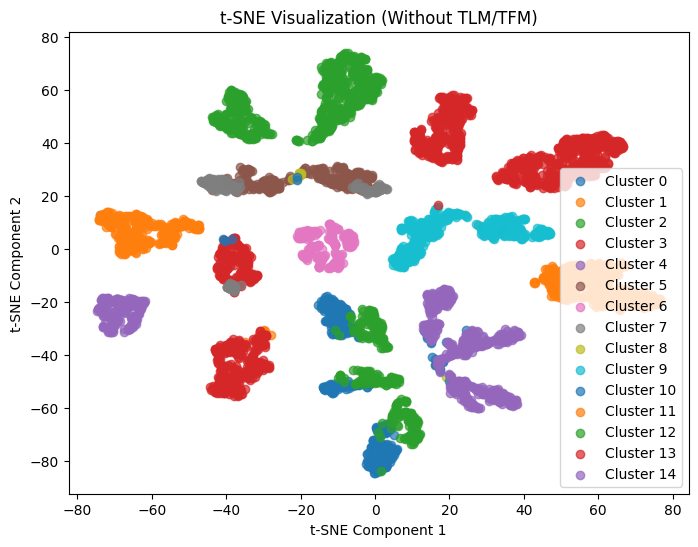

In [9]:
def plot_tsne(data_scaled, clusters, title):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(data_scaled)

    plt.figure(figsize=(8, 6))
    for cluster_id in np.unique(clusters):
        subset = tsne_result[clusters == cluster_id]
        plt.scatter(subset[:, 0], subset[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
    
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(title)
    plt.legend()
    plt.show()

plot_tsne(data_with_scaled, clusters_with, "t-SNE Visualization (With TLM/TFM)")
plot_tsne(data_without_scaled, clusters_without, "t-SNE Visualization (Without TLM/TFM)")

## For future: Creating subgroups for every clusters(now max 10 participants)

In [10]:
from sklearn.cluster import AgglomerativeClustering

def get_leaves(node_id, children, n_samples):
    stack = [node_id]
    leaves = []
    while stack:
        curr = stack.pop()
        if curr < n_samples:
            leaves.append(curr)
        else:
            child_left, child_right = children[curr - n_samples]
            stack.append(child_left)
            stack.append(child_right)
    return leaves

def cut_dendrogram_max_size(children, n_samples, max_size=10):
    root_id = 2 * n_samples - 2
    clusters = []
    
    stack = [root_id]
    while stack:
        node = stack.pop()
        leaves = get_leaves(node, children, n_samples)
        if len(leaves) <= max_size:
            clusters.append(leaves)
        else:
            if node < n_samples:
                clusters.append([node])
                continue
            left_child, right_child = children[node - n_samples]
            stack.append(left_child)
            stack.append(right_child)
    return clusters

def visualize_cluster_subgroups(
    cluster_df, 
    numerical_features, 
    categorical_features,
    max_subgroup_size=10
):
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_categorical = encoder.fit_transform(cluster_df[categorical_features])
    encoded_df = pd.DataFrame(
        encoded_categorical, 
        columns=encoder.get_feature_names_out(categorical_features)
    )

    data = pd.concat([cluster_df[numerical_features].reset_index(drop=True), encoded_df], axis=1)

    data_scaled = (data - data.mean()) / data.std()

    n_samples = len(data_scaled)
    agglo = AgglomerativeClustering(
        n_clusters=None, 
        distance_threshold=0  # Forces building the full tree
    )
    agglo.fit(data_scaled)


    children_ = agglo.children_
    clusters_list = cut_dendrogram_max_size(children_, n_samples, max_size=max_subgroup_size)

    final_labels = np.empty(n_samples, dtype=int)
    for label_id, leaf_indices in enumerate(clusters_list):
        for idx in leaf_indices:
            final_labels[idx] = label_id

    cluster_df = cluster_df.copy()
    cluster_df["subgroup"] = final_labels
    
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    data_tsne = tsne.fit_transform(data_scaled)

    plt.figure(figsize=(8, 6))
    num_subgroups = len(clusters_list)
    colors = plt.cm.get_cmap("gist_ncar", num_subgroups)

    for subgroup_label in range(num_subgroups):
        indices = (final_labels == subgroup_label)
        plt.scatter(
            data_tsne[indices, 0],
            data_tsne[indices, 1],
            color=colors(subgroup_label % 10),
            label=f"Subgroup {subgroup_label}",
            alpha=0.7,
            edgecolors="black"
        )

    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.title(f"Enforced ≤{max_subgroup_size} via Dendrogram Cut")
    plt.legend()
    plt.show()

    return cluster_df

def process_and_visualize_single_cluster(
    combined_df, 
    cluster_id, 
    numerical_features, 
    categorical_features, 
    max_subgroup_size=10
):
    cluster_df = combined_df[combined_df["cluster_with"] == cluster_id]

    if len(cluster_df) <= max_subgroup_size:
        cluster_df = cluster_df.copy()
        cluster_df["subgroup"] = 0
        return cluster_df

    updated_cluster_df = visualize_cluster_subgroups(
        cluster_df,
        numerical_features,
        categorical_features,
        max_subgroup_size
    )
    return updated_cluster_df

C:\Users\Pizhuk\AppData\Local\Temp\ipykernel_30972\3147515558.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("gist_ncar", num_subgroups)


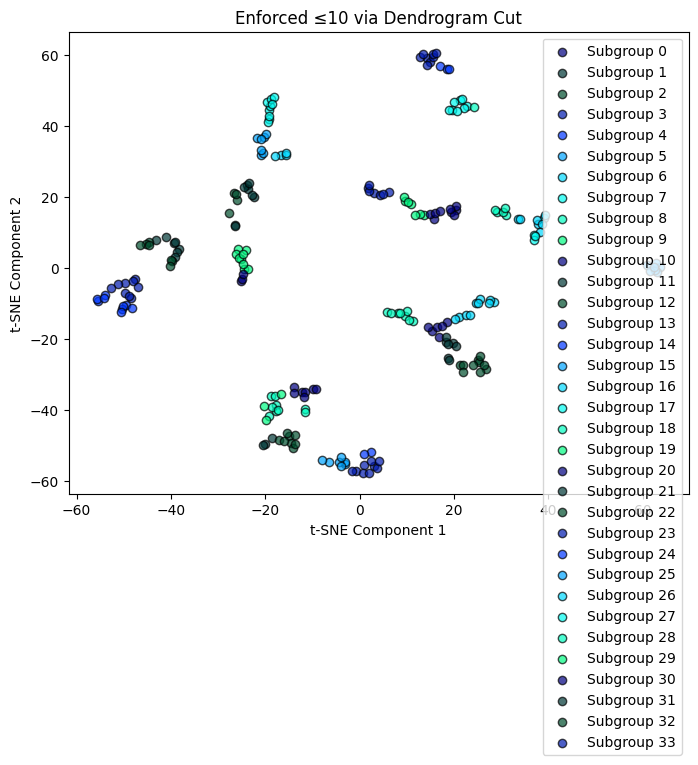

In [11]:
cluster_5_df = process_and_visualize_single_cluster(
    health_data_with_cv, 
    cluster_id=5, 
    numerical_features=["bmi", "age_in_months", "total_fat_mass", "total_lean_mass"], 
    categorical_features=["gender", "ethnicity", "cv_fitness_level"],
    max_subgroup_size=10
)

In [12]:
# subgroup_stats = cluster_5_df.groupby("subgroup")[numerical_features].describe()
# subgroup_stats.to_csv("subgroup_statistics.csv")